In [121]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

import quadkey

from geopy import distance
from tqdm import tqdm_notebook
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances

% matplotlib inline

In [173]:
!pip install geojson

In [174]:
import geojson
from folium import GeoJson
import branca.colormap as cm

In [122]:
%load_ext autoreload
%autoreload 2


In [123]:
np.random.seed(42)

In [124]:
from utils.postcodedata import read_postcode_data

In [162]:
from agents.agents import Survivor, Removed, Zombie

from utils.simulation_utils import move_one_random_step, \
                                   find_all_zombie_positions, \
                                   find_all_survivors_positions, \
                                   inherit_zombie_attributes, \
                                   inherit_survivor_attributes, \
                                   find_pairwise_distances, \
                                   find_matches, \
                                   run_duels, \
                                   timing

In [164]:
import quadkey

In [170]:
def get_quadkey_as_geojson(qk_object, properties=None):
        """Finds quadkey geojson"""

        q = qk_object

        (x, y), level = q.to_tile()
        top_left = quadkey.from_tile((x, y), level).to_geo()
        bottom_right = quadkey.from_tile((x + 1, y + 1), level).to_geo()

        # bottom row correction
        if top_left[0] < bottom_right[0]:
            bottom_right = (-bottom_right[0], bottom_right[1])
        # last column correction
        if top_left[1] > bottom_right[1]:
            bottom_right = (bottom_right[0], -bottom_right[1])

        coords = [top_left,
                  [top_left[0], bottom_right[1]],
                  bottom_right,
                  [bottom_right[0], top_left[1]],
                  top_left]

        coords = [[p[::-1] for p in coords]]
        gj = geojson.Feature(
                    geometry=geojson.Polygon(coords), properties=properties
                )

        return gj

In [126]:
# Read postcode data
path = r"data/postcodes/postcodes_data.csv"
df = read_postcode_data(path)

In [127]:
# Dundee Bounding Box
dundee_bbox = {'max_lat': 56.48412 ,
               'min_lat': 56.4513,
               'max_lon': -2.921649,
               'min_lon': -3.072711}

# 56.6336146,-3.28729


# dundee_bbox = {'max_lat': 56.656606,
#                'min_lat': 56.573105,
#                'max_lon': -3.121381,
#                'min_lon': -3.324284}


# Filter on Dundee
dundee = df[(df['Latitude'] > dundee_bbox["min_lat"]) & 
            (df['Latitude'] < dundee_bbox["max_lat"]) &
            (df['Longitude'] > dundee_bbox["min_lon"]) &
            (df['Longitude'] < dundee_bbox["max_lon"])]

# Initialize Population

In this section we initialize the population. We start from postcodes and their latitude and longitude location. For each postcode we know how many people are registered there based on 2011 UK Census, but we don't have any other information. Therefore we initialize each person at each postcode as a survivor, with random age and sex attributes. Based on those attributes we assign a speed.

Age distribution comes from ONS : https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/july2017

Speed by age was taken from an article at the following link:
https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age

How to adjust speed based on Age was derived from the article at the link below:
https://www.livescience.com/59289-why-men-run-faster-than-women.html



In [128]:
# Population inizialization parameter
avg_age = 40
std_age = 16
speed_by_age = pd.read_csv("data/SpeedAge.csv") # in meters per second
speeds_vector = speed_by_age['MetersSecond'].tolist()
male_women_speed_delta = 0.086
n_infected_at_start = 5
zombie_speed_ratio = 0.5

In [129]:
# Create population dictionary, at time 0 everybody is a survivor

top = dundee['Persons'].sum()
print("Total Population in Dundee: {}".format(top))

population = []

available_index = 0 #This is an ID assigned to each person

# Initialize Population assigning random attributes
for row in tqdm_notebook(dundee.itertuples()):
    
    if row.Persons == 0:
        pass 
    else:
        for person in range(row.Persons):
            
            available_index += 1
    
            survivor = Survivor()
    
            # Assign a random age
            survivor.age = np.clip(
                int(np.floor(np.random.normal(avg_age, std_age))), 0,100)
            
            # Assign a random sex (0.5 proabability of male)
            survivor.sex = np.random.choice(['M', 'F'])
        
            # Assign speed as a function of age and sex
            survivor.speed = speeds_vector[survivor.age]
            if survivor.sex == 'M':
                survivor.speed = survivor.speed * (1-male_women_speed_delta)
        
            # Assign latitude and longitude based on postcode location
            move_params = {'start_lat': row.Latitude,
                           'start_lon': row.Longitude,
                           'km': 0.01}
            dist, lat_n, lon_n = move_one_random_step(**move_params)
            survivor.latitude = lat_n
            survivor.longitude = lon_n
            #TODO add some random noise
            
            # Create Person Dictionary
            person_dict = {'id': available_index, 
                           'type': survivor}
            population.append(person_dict)


Total Population in Dundee: 84514


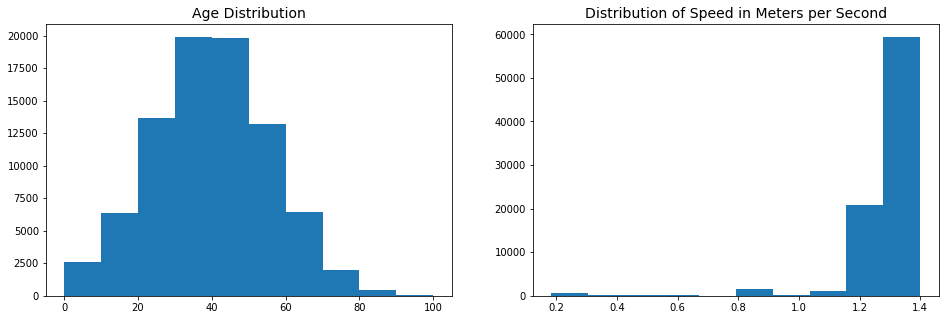

In [130]:
# Plot speed and age distributions
plt.figure(figsize = (16, 5))

plt.subplot(121)
plt.hist([x['type'].age for x in population])
plt.title('Age Distribution', size = 14)

plt.subplot(122)
plt.hist([x['type'].speed for x in population])
plt.title('Distribution of Speed in Meters per Second', size = 14)

plt.show()

In [131]:
# After initilizing the population infect random people
np.random.seed(42)

idx_first_infected = np.random.choice(
    range(len(population)), size = n_infected_at_start)

# Zombify first infected people
for idx in idx_first_infected:
    
    player = population[idx]['type']
    population[idx]['type'] = inherit_survivor_attributes(player, zombie_speed_ratio)

# Simulation

We simulate how the zombie outbreak would spread over days, by running a step for each hour.

1. We move each person a random step in latitude-longitude. Each person will move for a random fraction of the hour and won't move faster than their assigned walking speed. **NOTE**: for this first version of the simulation we will only have people moving on foot. Also, each hour people will decide whether to move or not based on a probability function. People are not allowed to move out of the bounding box, to simulate a close system, o a system where the balance of people moving in and moving out is null. 

2. After a move is made we check the pairwise distances of the zombies in the system with all the other survivors. If a zombie is close to a survivor then there will be a duel. This can end up with the zombification of the survivor, survival, or removal of the zombie.


In [140]:
# Simulation Parameters

move_prob = 0.1 # Probability a person will move or not
km = 1
survival_prob = 0.8
zombie_prob = 0.1
removal_prob = 0.1
time_steps = 10
threshold_distance = 0.013/40 #approx 25 meters
quadkey_level = 18

In [138]:
def move_one_random_step(
    start_lat, start_lon, km, iterations = 3, bbox=None, get_distance=False, verbose=False):

    # Select a random theta
    
    random_theta_a = np.random.choice(np.linspace(0, np.pi, 1000))
    random_theta_b = np.random.choice(np.linspace(np.pi, 2*np.pi, 1000))

    start_theta = np.random.choice([random_theta_a, random_theta_b])
    if start_theta == random_theta_a:
        alternative_theta = random_theta_b
    else:
        alternative_theta = random_theta_a

    # Find new random coordinates
    a_n = start_lat + (0.013*km) * np.cos(start_theta)
    b_n = start_lon + (0.013*km) * np.sin(start_theta)


    if bbox:
        iteration = 1
        valid_move = False
        while valid_move is False and iteration <= iterations:

            if (a_n > bbox['min_lat'] and
                a_n < bbox['max_lat'] and
                b_n > bbox['min_lon'] and
                b_n < bbox['max_lon']):
                valid_move = True

            else:
                iteration += 1
                a_n = start_lat + (0.013*(km/iteration) * np.cos(alternative_theta))
                b_n = start_lon + (0.013*(km/iteration) * np.sin(alternative_theta))
                if verbose:
                    print("Finding valid position, iter {}".format(iteration))

        # If still not within bounding box then go back to start
        if (a_n > bbox['min_lat'] and
            a_n < bbox['max_lat'] and
            b_n > bbox['min_lon'] and
            b_n < bbox['max_lon']):
            pass
        else:
            a_n = start_lat
            b_n = start_lon
            if verbose:
                print('Moved out bounding box, going back to default')
                print('----------------')

    if get_distance:
        dist = distance.distance((start_lat, start_lon), (a_n, b_n)).meters
    else:
        dist = np.nan

    return dist, a_n, b_n

In [153]:
# Start Simulation

# Move each person 1 step

for time_step in range(time_steps):
    
    dists = []
    
    # Move each player if it's a zombie or a survivor
    for p in tqdm_notebook(population):
        
        if p['type'].__repr__() in ['Survivor', 'Zombie']:
            
            # Change position only if player decides to move
            if np.random.choice([1,0], p = [move_prob, 1-move_prob]) == 1:
                
                # Find how far player will move in an hour in kilometers
                move_mins = np.clip(np.random.normal(30, 10,), a_min=0, a_max=60)
                km = (move_mins * 60 * p['type'].speed) / 1000
                
                # Move one random step and get new latitude longitude
                lat_s, lon_s = p['type'].latitude, p['type'].longitude
                move_params = {'start_lat': lat_s,
                               'start_lon': lon_s,
                               'km': km,
                               'bbox': dundee_bbox,
                               'iterations': 3,
                               'verbose' : False,
                               'get_distance': False}
                dist, lat_n, lon_n = move_one_random_step(**move_params)
                
                p['type'].path.append((lat_s, lon_s))
                p['type'].latitude = lat_n
                p['type'].longitude = lon_n
                
            else:
                pass
            
    # After all the population has made a move check who is close
    # to a zombie
    zombies, survivors, matches = find_pairwise_distances(population, quadkey_level)
    
    # Now that we have far is each player from each other
    # find the pairs that have less than 25 meters distance
    
    meetings = find_matches(matches, threshold_distance)
    dead_survivors, dead_zombies = run_duels(
        meetings, survival_prob, zombie_prob, removal_prob)
    
    for zs in dead_zombies:

        idx = zs[1][0]
        zombie_idx = zombies[idx][0]
        player = population[zombie_idx-1]['type']

        new_state = inherit_zombie_attributes(player)
        population[zombie_idx-1]['type'] = new_state
        
        
    for ds in dead_survivors:
    
        idx = ds[1][1]
        surv_idx = survivors[idx][0]
        player = population[surv_idx-1]['type']

        new_state = inherit_survivor_attributes(player, zombie_speed_ratio)
        population[surv_idx-1]['type'] = new_state

    print(len(list(filter(lambda x: x['type'].__repr__() == 'Removed', population))))
    print(len(list(filter(lambda x: x['type'].__repr__() == 'Zombie', population))))


1403 Zombies
10623 Candidate Survivors
Elapsed time: 28.844529151916504
3686
1507



1507 Zombies
10876 Candidate Survivors
Elapsed time: 24.427828073501587
4185
1637



1637 Zombies
11179 Candidate Survivors
Elapsed time: 28.81553888320923
4727
1757



1757 Zombies
11942 Candidate Survivors
Elapsed time: 33.585846185684204
5323
1835



1835 Zombies
12233 Candidate Survivors
Elapsed time: 32.00825881958008
5912
1962



1962 Zombies
13229 Candidate Survivors
Elapsed time: 47.539978981018066
6502
2156



2156 Zombies
14316 Candidate Survivors
Elapsed time: 66.88568186759949
7195
2340



2340 Zombies
15275 Candidate Survivors


KeyboardInterrupt: 

In [384]:
# Stato of the population

rem = list(filter(lambda x: x['type'].__repr__() == 'Removed', population))
print(f"After {time_steps} extra time steps {len(rem)} players removed")
zom = list(filter(lambda x: x['type'].__repr__() == 'Zombie', population))
print(f"After {time_steps} extra time steps {len(zom)} zombies")
surv = list(filter(lambda x: x['type'].__repr__() == 'Survivor', population))
print(f"After {time_steps} extra time steps {len(surv)} survivors are left")

After 10 extra time steps 7195 players removed
After 10 extra time steps 2340 zombies
After 10 extra time steps 74979 survivors are left


# Map

In [376]:
# Find all quadkeys

all_pops = [(x['type'].latitude, x['type'].longitude) for x in population]
qks_str = [str(quadkey.from_geo(pop, 17)) for pop in all_pops]

In [377]:
# Create a quadkey dataframe
qks_df = pd.DataFrame(pd.Series(qks_str).value_counts()).reset_index()
qks_df.columns = ['Quadkey', 'Frequency']

# Find zombie dataframe
zom_qk = [str(quadkey.from_geo(x[1], 17)) for x in zombies]
zom_qk = pd.DataFrame(pd.Series(zom_qk).value_counts()).reset_index()
zom_qk.columns = ['Quadkey', 'Frequency']

# Join the two dataframes
zom_freqs = pd.merge(qks_df.drop('Frequency', 1), zom_qk, on = 'Quadkey', how = 'left')
zom_freqs.fillna(0, inplace = True)

In [385]:
### Plot where zombies are spread

# Find zombie dataframe
zom_qk = [str(quadkey.from_geo(x[1], 17)) for x in zombies]
zom_qk = pd.DataFrame(pd.Series(zom_qk).value_counts()).reset_index()
zom_qk.columns = ['Quadkey', 'Frequency']

# Join the two dataframes
zom_freqs = pd.merge(qks_df.drop('Frequency', 1), zom_qk, on = 'Quadkey', how = 'left')
zom_freqs.fillna(0, inplace = True)

In [386]:
# Initialize Map
centroid = np.median(dundee['Latitude']), np.median(dundee['Longitude'])
m = folium.Map(centroid, zoom_start=13)

# Create Color Map
linear = cm.LinearColormap(['green', 'yellow', 'red'],
                vmin=zom_freqs["Frequency"].min(), 
                vmax=zom_freqs["Frequency"].max())


for idx, q in zom_freqs.iterrows():
    qk = quadkey.QuadKey(q["Quadkey"])
    col = linear(q["Frequency"])
    
    geoj = get_quadkey_as_geojson(qk)
    geoj["properties"] = {"style": {"fillColor":q["Frequency"]}}

Gj = GeoJson(
            dict({'type': 'FeatureCollection', 'features':geojs}),
            style_function=lambda feature: {
                'fillColor': linear(feature['properties']['style']['fillColor']),
                'color': linear(feature['properties']['style']['fillColor']),
                'weight': 0.5,
                'dashArray': '5, 5'
            }
        )

Gj.add_to(m)

cm.caption = 'A colormap caption'
m.add_child(linear)


In [160]:
import folium

centroid = np.median(dundee['Latitude']), np.median(dundee['Longitude'])
m = folium.Map(centroid, zoom_start=13)

points = list(zip(dundee['Longitude'], dundee['Latitude']))

for point in zombie_pos:
    
    folium.CircleMarker(point, radius = 0.5, color = 'red').add_to(m)
    
# for point in rem_pos:
#     folium.CircleMarker(point, radius = 0.5, color = 'green', alpha = 0.5).add_to(m)
m

In [68]:
# random_theta = np.linspace(0, 2*np.pi, 1000)

# km = 1
# a_n = 1 + (0.013*km) * np.cos(random_theta)
# b_n = 1 + (0.013*km) * np.sin(random_theta)

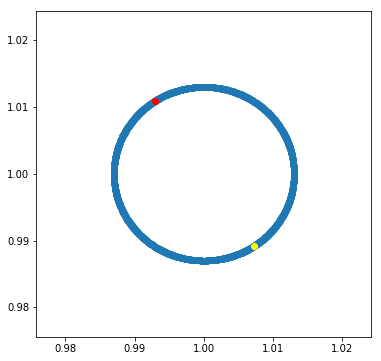

In [120]:
# plt.figure(figsize = (6,6))
# plt.scatter(a_n, b_n)
# plt.scatter(a_nn, b_nn, color = 'red')
# plt.scatter(a_nnn, b_nnn, color = 'yellow')